In [1]:
import pandas as pd
import glob
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import joblib
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load cleaned data
files = sorted(glob.glob('../data/products_clean_part_*.parquet'))
df_clean = pd.concat([pd.read_parquet(f) for f in files], ignore_index=True)

df_sample=df_clean.sample(10_000, random_state=42)

# Let's define the predictors from the 
X_sample = df_sample[['title', 'description', 'feature', 'brand', 'price']]
y_sample = df_sample['main_cat_grouped']

X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, stratify=y_sample, test_size=0.2, random_state=42)

## Adjusting hyperparameters:

- Trying different Loss functions
I am not 100% sure which loss function will performe better with such a large dataset. Addiitonally, since the class is imabalanced, I am going to try to improve the accuracy and general recall if possible.
- Some hyperparameters that could impact performanc: penalty type (l1 or l2 regularization), the regularization strength (alpha), and parameters of the TF-IDF vectorizer.
- Optimizing learning rate

In [3]:
preprocessor = ColumnTransformer(
    transformers=[
        ('title_tfidf', TfidfVectorizer(max_features=5000), 'title'),
        ('desc_tfidf', TfidfVectorizer(max_features=5000), 'description'),
        ('feature_tfidf', TfidfVectorizer(max_features=3000), 'feature'),
        ('brand_tfidf', TfidfVectorizer(max_features=1000), 'brand'),
        ('scaler', StandardScaler(), ['price']),
    ],
    remainder='drop'
)

pipeline1 = Pipeline([
    ('preprocessing', preprocessor),
    ('cls', SGDClassifier(class_weight='balanced', max_iter=1000, n_jobs=-1, random_state=42))
])

In [4]:
# Hyperparameters options to evaluate
param_grid = {
    "cls__loss": ["log_loss"],  
    "cls__penalty": ["l2", "l1"],
    "cls__alpha": [1e-4, 1e-5, 1e-6], # Regularization
    "cls__learning_rate": ["constant", "optimal", "adaptive"],
    "cls__eta0": [0.001, 0.01, 0.1], # For constant and adaptive
    "cls__max_iter": [1000, 2000], # Iterations number
}

search = GridSearchCV(
    pipeline1,
    param_grid,
    scoring="balanced_accuracy",
    cv=3,
    verbose=2,
    n_jobs=-1,
)

search.fit(X_sample, y_sample)

print("\n Best parameters:", search.best_params_)
print("\n Best balanced balanced accuracy:", search.best_score_)


Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END cls__alpha=0.0001, cls__eta0=0.001, cls__learning_rate=constant, cls__loss=log_loss, cls__max_iter=1000, cls__penalty=l2; total time=   8.1s
[CV] END cls__alpha=0.0001, cls__eta0=0.001, cls__learning_rate=constant, cls__loss=log_loss, cls__max_iter=1000, cls__penalty=l2; total time=   7.9s
[CV] END cls__alpha=0.0001, cls__eta0=0.001, cls__learning_rate=constant, cls__loss=log_loss, cls__max_iter=1000, cls__penalty=l2; total time=   7.9s
[CV] END cls__alpha=0.0001, cls__eta0=0.001, cls__learning_rate=constant, cls__loss=log_loss, cls__max_iter=2000, cls__penalty=l2; total time=   8.0s
[CV] END cls__alpha=0.0001, cls__eta0=0.001, cls__learning_rate=constant, cls__loss=log_loss, cls__max_iter=2000, cls__penalty=l2; total time=   8.1s
[CV] END cls__alpha=0.0001, cls__eta0=0.001, cls__learning_rate=constant, cls__loss=log_loss, cls__max_iter=1000, cls__penalty=l1; total time=   8.4s
[CV] END cls__alpha=0.0001, cls__eta0

## Fitting and Evaluation of Improved Model

In [7]:
# Define el clasificador con los mejores parámetros
# penalty='l2' already by default
model2 = SGDClassifier(
    alpha=1e-6,
    eta0=0.01,
    learning_rate='adaptive',
    loss='log_loss',
    max_iter=1000,
    random_state=42,
)

# Pipeline final
pipeline2= Pipeline([
    ("preprocessing", preprocessor),
    ("cls", model2)
])

# Train the second model with the sample dataset
pipeline2.fit(X_sample, y_sample)

y_pred = pipeline2.predict(X_sample)

Accuracy: 0.8947

Classification Report:
                            precision    recall  f1-score   support

          All Electronics       0.86      0.64      0.73       554
           Amazon Fashion       0.93      0.99      0.96       684
              Amazon Home       0.87      0.92      0.89       850
    Arts, Crafts & Sewing       0.93      0.92      0.92       723
               Automotive       0.92      0.95      0.93       629
           Camera & Photo       0.87      0.88      0.88       401
Cell Phones & Accessories       0.85      0.89      0.87       527
                Computers       0.85      0.91      0.88       741
     Home Audio & Theater       0.84      0.85      0.84       362
  Industrial & Scientific       1.00      0.02      0.04        95
      Musical Instruments       0.97      0.91      0.94       401
          Office Products       0.88      0.91      0.89       802
                    Other       0.00      0.00      0.00        16
             Pet Su

/home/Teresa_Ballester/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/Teresa_Ballester/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/Teresa_Ballester/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

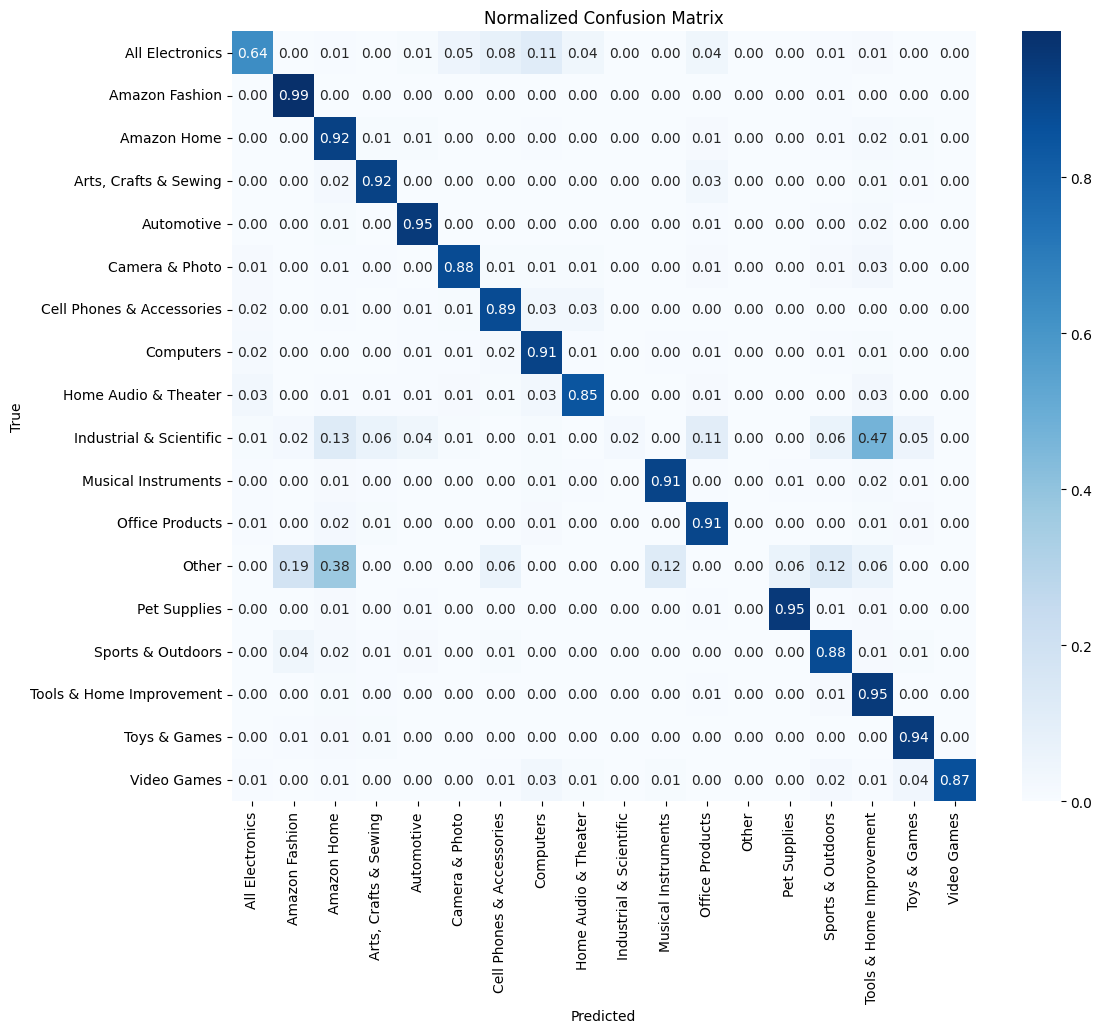

In [8]:
## Evaluation
print("Accuracy:", accuracy_score(y_sample, y_pred))
print("\nClassification Report:\n", classification_report(y_sample, y_pred))

cm = confusion_matrix(y_sample, y_pred, normalize='true')
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', xticklabels=pipeline2.classes_, yticklabels=pipeline2.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix")
plt.show()

The problem with this model is that it does not predict well all brand categories. For that, I will be testing a fer more adjustments, but I will stick with first model found in preprocessing_training.ipynb notebook.